In [ ]:
!ls

pdb_data_seq.csv  sample_data  sequence.fasta


In [ ]:
from Bio import SeqIO

# Path to your FASTA file (update based on your file location)
fasta_file = "sequence.fasta"  # Or "/content/drive/MyDrive/protein.fasta"

# Read and display the FASTA file
for record in SeqIO.parse(fasta_file, "fasta"):
    print(f"ID: {record.id}")
    print(f"Sequence: {record.seq}")
    print("-" * 50)

ID: BAG32277.1
Sequence: MANLGCWMLVLFVATWSDLGLCKKRPKPGGWNTGGSRYPGQGSPGGNRYPPQGGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQPHGGGWGQGGGTHSQWNKPSKPKTNMKHMAGAAAAGAVVGGLGGYVLGSAMSRPIIHFGSDYEDRYYRENMHRYPNQVYYRPMDEYSNQNNFVHDCVNITIKQHTVTTTTKGENFTETDVKMMERVVEQMCITQYERESQAYYQRGSSMVLFSSPPVILLISFLIFLIVG
--------------------------------------------------


Using device: cuda
Train size: 8678
Validation size: 2170
Test CB513 size: 513
Test CASP12 size: 21
Test TS115 size: 115
Model parameters: 367,491
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch [1/10] Complete
Train Loss: 1.0220, Train Acc: 0.4780
Val Loss: 0.9743, Val Acc: 0.5230
Epoch [2/10] Complete
Train Loss: 0.9803, Train Acc: 0.5177
Val Loss: 0.9695, Val Acc: 0.5238
Epoch [3/10] Complete
Train Loss: 0.9754, Train Acc: 0.5204
Val Loss: 0.9646, Val Acc: 0.5274
Epoch [4/10] Complete
Train Loss: 0.9732, Train Acc: 0.5214
Val Loss: 0.9635, Val Acc: 0.5273
Epoch [5/10] Complete
Train Loss: 0.9710, Train Acc: 0.5228
Val Loss: 0.9680, Val Acc: 0.5253
Epoch [6/10] Complete
Train Loss: 0.9711, Train Acc: 0.5228
Val Loss: 0.9627, Val Acc: 0.5287
Epoch [7/10] Complete
Train Loss: 0.9696, Train Acc: 0.5237
Val Loss: 0.9626, Val Acc: 0.5281
Epoch [8/10] Complete
Train Loss: 0.9686, Train Acc: 0.5244
Val Loss: 0.9615, Val Acc: 0.5294
Epoch [9/10] Complete
Train Loss: 0.9684, Train Acc: 0.5245
Val Loss: 0.9601, Val Acc: 0.5297
Epoch [10/10] Complete
Train Loss: 0.9679, Train Acc: 0.5250
Val Loss: 0.9604, Val Acc: 0.5293


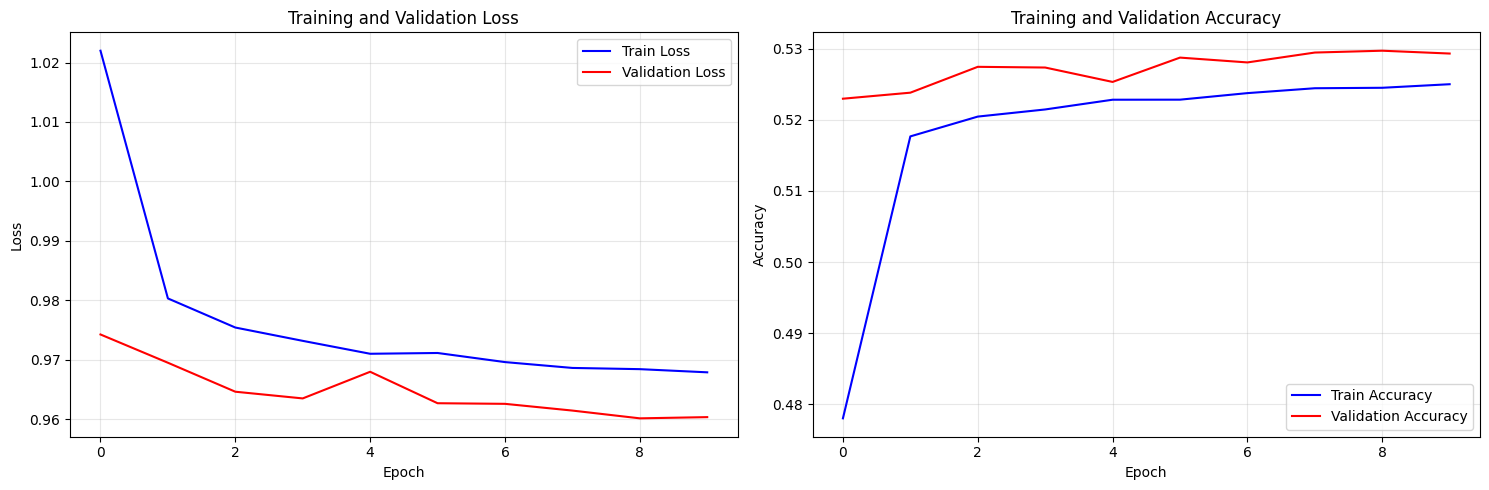

Creating weight update GIFs...
GIF saved to weight_gifs/embedding_weight_updates.gif
GIF saved to weight_gifs/transformer_encoder_layers_0_self_attn_in_proj_weight_updates.gif
GIF saved to weight_gifs/transformer_encoder_layers_0_linear1_weight_updates.gif
GIF saved to weight_gifs/classifier_0_weight_updates.gif
GIF files created in 'weight_gifs' folder:
- embedding_weight_updates.gif
- transformer_encoder_layers_0_self_attn_in_proj_weight_updates.gif
- transformer_encoder_layers_0_linear1_weight_updates.gif
- classifier_0_weight_updates.gif

To view GIFs in Colab, use:
from IPython.display import Image, display
display(Image('weight_gifs/embedding_weight_updates.gif'))

Evaluating on CB513 test set...

CB513 Results:
Evaluation Metrics:
Accuracy: 0.5159
Precision: 0.5083
Recall: 0.5159
F1-Score: 0.5088

Per-class Metrics:
H (Helix):
  Precision: 0.5150
  Recall: 0.4650
  F1-Score: 0.4888
E (Strand):
  Precision: 0.4128
  Recall: 0.3265
  F1-Score: 0.3646
C (Coil):
  Precision: 0.5514


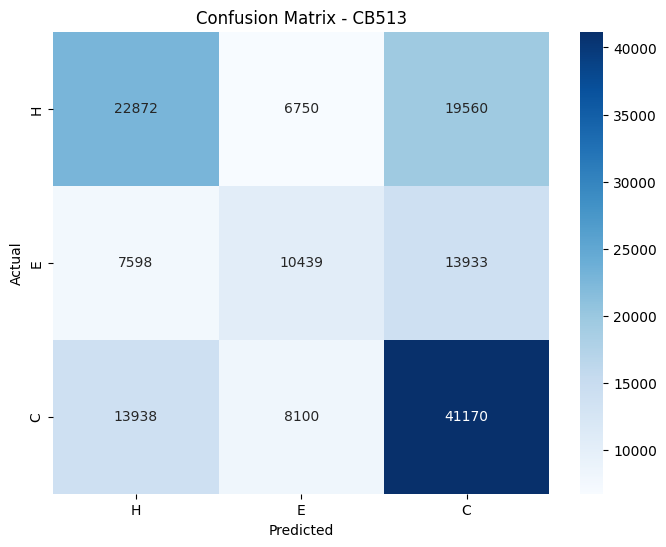


Evaluating on CASP12 test set...

CASP12 Results:
Evaluation Metrics:
Accuracy: 0.5510
Precision: 0.5488
Recall: 0.5510
F1-Score: 0.5465

Per-class Metrics:
H (Helix):
  Precision: 0.5035
  Recall: 0.5797
  F1-Score: 0.5389
E (Strand):
  Precision: 0.4867
  Recall: 0.3447
  F1-Score: 0.4036
C (Coil):
  Precision: 0.6039
  Recall: 0.6195
  F1-Score: 0.6116


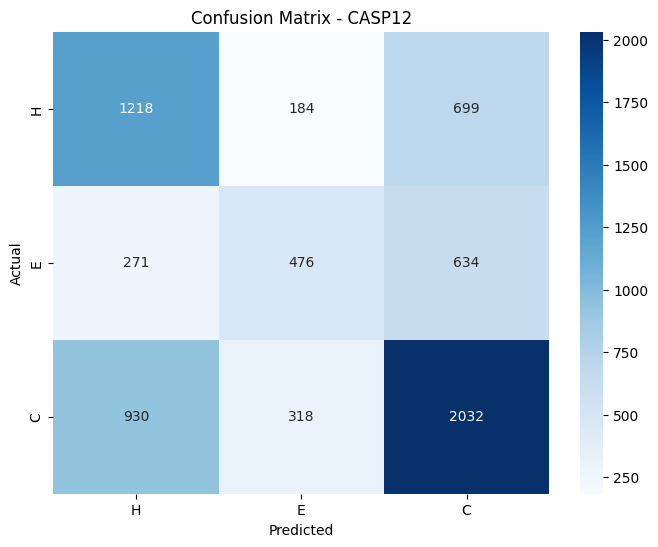


Evaluating on TS115 test set...

TS115 Results:
Evaluation Metrics:
Accuracy: 0.5598
Precision: 0.5528
Recall: 0.5598
F1-Score: 0.5541

Per-class Metrics:
H (Helix):
  Precision: 0.5816
  Recall: 0.6218
  F1-Score: 0.6010
E (Strand):
  Precision: 0.4385
  Recall: 0.3178
  F1-Score: 0.3685
C (Coil):
  Precision: 0.5750
  Recall: 0.6059
  F1-Score: 0.5900


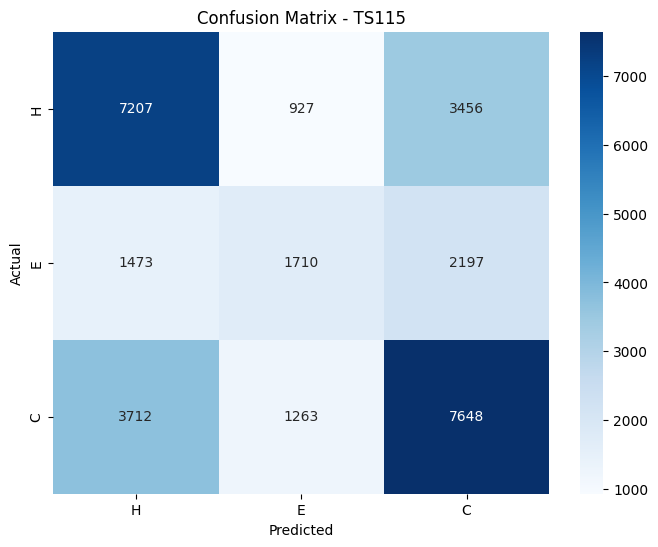

Training and evaluation complete!
Training and evaluation complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from PIL import Image
import io
import math
from collections import defaultdict
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model Configuration
class ModelConfig:
    def __init__(self):
        # Model architecture
        self.vocab_size = 22  # 20 AA + unknown + padding
        self.d_model = 64
        self.nhead = 8
        self.num_layers = 6
        self.num_classes = 3
        self.max_length = 1000
        self.dropout = 0.1

        # Training parameters
        self.batch_size = 128
        self.num_epochs = 10
        self.learning_rate = 5e-4
        self.weight_decay = 5e-5
        self.train_log_interval = 100
        self.eval_interval = 1000

# Data preprocessing
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_TO_IDX = {aa: idx for idx, aa in enumerate(AA_LIST)}
LABEL_MAP = {'H': 0, 'E': 1, 'C': 2}

# Weight tracking for GIF creation
class WeightTracker:
    def __init__(self, model):
        self.model = model
        self.weight_history = defaultdict(list)

    def record_weights(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and len(param.shape) >= 2:  # Only track 2D+ weights
                self.weight_history[name].append(param.data.cpu().numpy().copy())

    def create_weight_gif(self, layer_name, save_path, fps=2):
        if layer_name not in self.weight_history:
            print(f"Layer {layer_name} not found in weight history")
            return

        weights = self.weight_history[layer_name]
        if not weights:
            return

        images = []
        for epoch, weight in enumerate(weights):
            fig, ax = plt.subplots(figsize=(10, 8))

            # For 2D weights, show as heatmap
            if len(weight.shape) == 2:
                im = ax.imshow(weight, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
                plt.colorbar(im)
            # For higher dimensional weights, take a 2D slice
            elif len(weight.shape) > 2:
                weight_2d = weight.reshape(weight.shape[0], -1)
                im = ax.imshow(weight_2d, cmap='RdBu', aspect='auto', vmin=-0.5, vmax=0.5)
                plt.colorbar(im)

            ax.set_title(f'{layer_name} - Epoch {epoch + 1}')

            # Save plot to bytes
            buf = io.BytesIO()
            plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
            buf.seek(0)
            images.append(Image.open(buf))
            plt.close()

        # Create GIF
        if images:
            images[0].save(save_path, save_all=True, append_images=images[1:],
                          duration=1000//fps, loop=0)
            print(f"GIF saved to {save_path}")

    def create_all_gifs(self, output_dir='weight_gifs'):
        os.makedirs(output_dir, exist_ok=True)

        # Create GIFs for key layers
        key_layers = [
            'embedding.weight',
            'transformer_encoder.layers.0.self_attn.in_proj_weight',
            'transformer_encoder.layers.0.linear1.weight',
            'classifier.0.weight'
        ]

        for layer_name in key_layers:
            if layer_name in self.weight_history:
                safe_name = layer_name.replace('.', '_').replace('/', '_')
                gif_path = os.path.join(output_dir, f'{safe_name}_updates.gif')
                self.create_weight_gif(layer_name, gif_path, fps=1)


class ProteinDataset(Dataset):
    def __init__(self, dataframe, aa_to_idx, label_map, max_length=None):
        self.sequences = dataframe['seq'].tolist()
        self.labels = dataframe['sst3'].tolist()
        self.aa_to_idx = aa_to_idx
        self.label_map = label_map

        if max_length is None:
            self.max_length = max(len(seq) for seq in self.sequences)
        else:
            self.max_length = max_length

    def __len__(self):
        return len(self.sequences)

    def tokenize_sequence(self, seq):
        tokens = []
        for aa in seq:
            if aa in self.aa_to_idx:
                tokens.append(self.aa_to_idx[aa])
            else:
                tokens.append(20)  # Unknown amino acid token
        return tokens

    def encode_labels(self, labels):
        return [self.label_map[l] for l in labels]

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        labels = self.labels[idx]

        seq_tokens = self.tokenize_sequence(seq)
        label_tokens = self.encode_labels(labels)

        if len(seq_tokens) > self.max_length:
            seq_tokens = seq_tokens[:self.max_length]
            label_tokens = label_tokens[:self.max_length]
        else:
            pad_length = self.max_length - len(seq_tokens)
            seq_tokens.extend([21] * pad_length)  # Padding token for sequence
            label_tokens.extend([-1] * pad_length)  # Ignore token for labels

        return {
            'sequence': torch.tensor(seq_tokens, dtype=torch.long),
            'labels': torch.tensor(label_tokens, dtype=torch.long),
            'length': torch.tensor(min(len(seq), self.max_length), dtype=torch.long)
        }

# Encoder-only Transformer for Protein Structure Prediction
class ProteinStructureTransformer(nn.Module):
    def __init__(self, config):
        super(ProteinStructureTransformer, self).__init__()

        self.d_model = config.d_model
        self.embedding = nn.Embedding(config.vocab_size, config.d_model)

        # Learned positional embedding (simpler than sinusoidal)
        self.pos_embedding = nn.Embedding(config.max_length, config.d_model)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model,
            nhead=config.nhead,
            dim_feedforward=config.d_model * 4,
            dropout=config.dropout,
            activation='relu',
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=config.num_layers
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(config.d_model, config.d_model // 2),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_model // 2, config.num_classes)
        )

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, src, src_padding_mask=None):
        # src: [batch_size, seq_len]
        batch_size, seq_len = src.shape

        # Create position indices
        positions = torch.arange(seq_len, device=src.device).unsqueeze(0).expand(batch_size, -1)

        # Embedding and positional encoding
        src_emb = self.embedding(src) * math.sqrt(self.d_model)  # [batch_size, seq_len, d_model]
        pos_emb = self.pos_embedding(positions)  # [batch_size, seq_len, d_model]

        # Add embeddings
        src_emb = src_emb + pos_emb
        src_emb = self.dropout(src_emb)

        # Transformer encoding
        memory = self.transformer_encoder(src_emb, src_key_padding_mask=src_padding_mask)

        # Classification
        output = self.classifier(memory)  # [batch_size, seq_len, num_classes]

        return output

# Training function
def train_model(model, train_loader, val_loader, config):
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    # Weight tracker for GIFs
    weight_tracker = WeightTracker(model)

    # Training history
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    model.to(device)
    global_step = 0

    for epoch in range(config.num_epochs):
        # Record weights at the beginning of each epoch
        weight_tracker.record_weights()

        # Training phase
        model.train()
        epoch_train_loss = 0
        epoch_train_correct = 0
        epoch_train_tokens = 0

        for batch_idx, batch in enumerate(train_loader):
            sequences = batch['sequence'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['length'].to(device)

            # Create padding mask
            padding_mask = (sequences == 21)  # Padding token

            optimizer.zero_grad()
            outputs = model(sequences, src_padding_mask=padding_mask)

            # Reshape for loss calculation
            outputs = outputs.view(-1, 3)
            labels = labels.view(-1)

            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            global_step += 1

            epoch_train_loss += loss.item()

            # Calculate accuracy (excluding padding tokens)
            valid_mask = labels != -1
            if valid_mask.sum() > 0:
                predictions = torch.argmax(outputs, dim=1)
                correct = (predictions == labels) & valid_mask
                epoch_train_correct += correct.sum().item()
                epoch_train_tokens += valid_mask.sum().item()

            # Log training progress
            if (batch_idx + 1) % config.train_log_interval == 0:
                current_loss = epoch_train_loss / (batch_idx + 1)
                current_acc = epoch_train_correct / epoch_train_tokens if epoch_train_tokens > 0 else 0
                print(f'Epoch [{epoch+1}/{config.num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {current_loss:.4f}, Acc: {current_acc:.4f}')

            # Evaluate on validation set
            if global_step % config.eval_interval == 0:
                model.eval()
                val_loss = 0
                val_correct = 0
                val_tokens = 0

                with torch.no_grad():
                    for val_batch in val_loader:
                        val_sequences = val_batch['sequence'].to(device)
                        val_labels = val_batch['labels'].to(device)

                        val_padding_mask = (val_sequences == 21)
                        val_outputs = model(val_sequences, src_padding_mask=val_padding_mask)

                        val_outputs = val_outputs.view(-1, 3)
                        val_labels = val_labels.view(-1)

                        val_loss += criterion(val_outputs, val_labels).item()

                        valid_mask = val_labels != -1
                        if valid_mask.sum() > 0:
                            predictions = torch.argmax(val_outputs, dim=1)
                            correct = (predictions == val_labels) & valid_mask
                            val_correct += correct.sum().item()
                            val_tokens += valid_mask.sum().item()

                avg_val_loss = val_loss / len(val_loader)
                val_accuracy = val_correct / val_tokens if val_tokens > 0 else 0

                val_losses.append(avg_val_loss)
                val_accuracies.append(val_accuracy)

                print(f'Step {global_step} - Validation Loss: {avg_val_loss:.4f}, '
                      f'Validation Acc: {val_accuracy:.4f}')
                print('-' * 60)

                model.train()  # Back to training mode

        # End of epoch validation (always do full validation at end of epoch)
        model.eval()
        epoch_val_loss = 0
        epoch_val_correct = 0
        epoch_val_tokens = 0

        with torch.no_grad():
            for val_batch in val_loader:
                val_sequences = val_batch['sequence'].to(device)
                val_labels = val_batch['labels'].to(device)

                val_padding_mask = (val_sequences == 21)
                val_outputs = model(val_sequences, src_padding_mask=val_padding_mask)

                val_outputs = val_outputs.view(-1, 3)
                val_labels = val_labels.view(-1)

                epoch_val_loss += criterion(val_outputs, val_labels).item()

                valid_mask = val_labels != -1
                if valid_mask.sum() > 0:
                    predictions = torch.argmax(val_outputs, dim=1)
                    correct = (predictions == val_labels) & valid_mask
                    epoch_val_correct += correct.sum().item()
                    epoch_val_tokens += valid_mask.sum().item()

        # End of epoch statistics
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_accuracy = epoch_train_correct / epoch_train_tokens if epoch_train_tokens > 0 else 0
        val_accuracy = epoch_val_correct / epoch_val_tokens if epoch_val_tokens > 0 else 0

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch+1}/{config.num_epochs}] Complete')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        print('=' * 60)

    # Record final weights
    weight_tracker.record_weights()

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'weight_tracker': weight_tracker
    }

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['labels'].to(device)

            padding_mask = (sequences == 21)
            outputs = model(sequences, src_padding_mask=padding_mask)

            # Get predictions
            predictions = torch.argmax(outputs, dim=-1)

            # Flatten and filter valid positions
            batch_size, seq_len = labels.shape
            for i in range(batch_size):
                valid_positions = labels[i] != -1
                if valid_positions.sum() > 0:
                    all_predictions.extend(predictions[i][valid_positions].cpu().numpy())
                    all_labels.extend(labels[i][valid_positions].cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

# Plotting functions
def plot_training_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(history['train_losses'], label='Train Loss', color='blue')
    ax1.plot(history['val_losses'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy curves
    ax2.plot(history['train_accuracies'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=['H', 'E', 'C'], title='Confusion Matrix', save_name='confusion_matrix.png'):
    """
    Plot confusion matrix with custom title and save name
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()

    return cm

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print("Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=[0, 1, 2]
    )

    class_names = ['H (Helix)', 'E (Strand)', 'C (Coil)']
    print("\nPer-class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  F1-Score: {f1_per_class[i]:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'per_class_metrics': {
            'precision': precision_per_class,
            'recall': recall_per_class,
            'f1': f1_per_class
        }
    }

# Main execution function
def main():
    # Initialize configuration
    config = ModelConfig()

    # Load your actual data
    train_df = pd.read_csv("training_secondary_structure_train.csv")
    val_df = pd.read_csv("validation_secondary_structure_valid.csv")
    test_df_cb513 = pd.read_csv("test_secondary_structure_cb513.csv")
    test_df_casp12 = pd.read_csv("test_secondary_structure_casp12.csv")
    test_df_ts115 = pd.read_csv("test_secondary_structure_ts115.csv")

    # Select relevant columns
    train_df = train_df[['seq', 'sst3']]
    val_df = val_df[['seq', 'sst3']]
    test_df_cb513 = test_df_cb513[['seq', 'sst3']]
    test_df_casp12 = test_df_casp12[['seq', 'sst3']]
    test_df_ts115 = test_df_ts115[['seq', 'sst3']]

    print(f"Train size: {len(train_df)}")
    print(f"Validation size: {len(val_df)}")
    print(f"Test CB513 size: {len(test_df_cb513)}")
    print(f"Test CASP12 size: {len(test_df_casp12)}")
    print(f"Test TS115 size: {len(test_df_ts115)}")

    # Create datasets
    train_dataset = ProteinDataset(train_df, AA_TO_IDX, LABEL_MAP, config.max_length)
    val_dataset = ProteinDataset(val_df, AA_TO_IDX, LABEL_MAP, config.max_length)
    test_dataset_cb513 = ProteinDataset(test_df_cb513, AA_TO_IDX, LABEL_MAP, config.max_length)
    test_dataset_casp12 = ProteinDataset(test_df_casp12, AA_TO_IDX, LABEL_MAP, config.max_length)
    test_dataset_ts115 = ProteinDataset(test_df_ts115, AA_TO_IDX, LABEL_MAP, config.max_length)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader_cb513 = DataLoader(test_dataset_cb513, batch_size=config.batch_size, shuffle=False)
    test_loader_casp12 = DataLoader(test_dataset_casp12, batch_size=config.batch_size, shuffle=False)
    test_loader_ts115 = DataLoader(test_dataset_ts115, batch_size=config.batch_size, shuffle=False)

    # Initialize model
    model = ProteinStructureTransformer(config)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    print("Starting training...")
    history = train_model(model, train_loader, val_loader, config)

    # Plot training curves
    plot_training_curves(history)

    # Create weight update GIFs
    print("Creating weight update GIFs...")
    weight_tracker = history['weight_tracker']
    weight_tracker.create_all_gifs()

    print("GIF files created in 'weight_gifs' folder:")
    print("- embedding_weight_updates.gif")
    print("- transformer_encoder_layers_0_self_attn_in_proj_weight_updates.gif")
    print("- transformer_encoder_layers_0_linear1_weight_updates.gif")
    print("- classifier_0_weight_updates.gif")
    print("\nTo view GIFs in Colab, use:")
    print("from IPython.display import Image, display")
    print("display(Image('weight_gifs/embedding_weight_updates.gif'))")

    # Evaluate on all test sets
    test_sets = {
        'CB513': test_loader_cb513,
        'CASP12': test_loader_casp12,
        'TS115': test_loader_ts115
    }

    for test_name, test_loader in test_sets.items():
        print(f"\nEvaluating on {test_name} test set...")
        y_pred, y_true = evaluate_model(model, test_loader)

        # Calculate metrics
        print(f"\n{test_name} Results:")
        metrics = calculate_metrics(y_true, y_pred)

        # Plot confusion matrix with proper title and save name
        cm = plot_confusion_matrix(
            y_true, y_pred,
            class_names=['H', 'E', 'C'],
            title=f'Confusion Matrix - {test_name}',
            save_name=f'confusion_matrix_{test_name.lower()}.png'
        )

    print("Training and evaluation complete!")

    return model, history



# Run the main function
model, history = main()
print("Training and evaluation complete!")

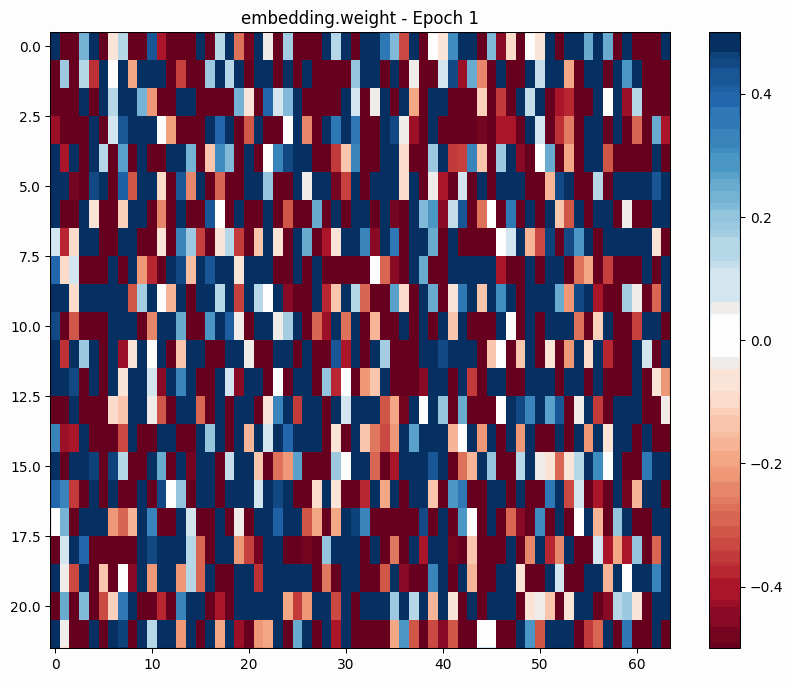

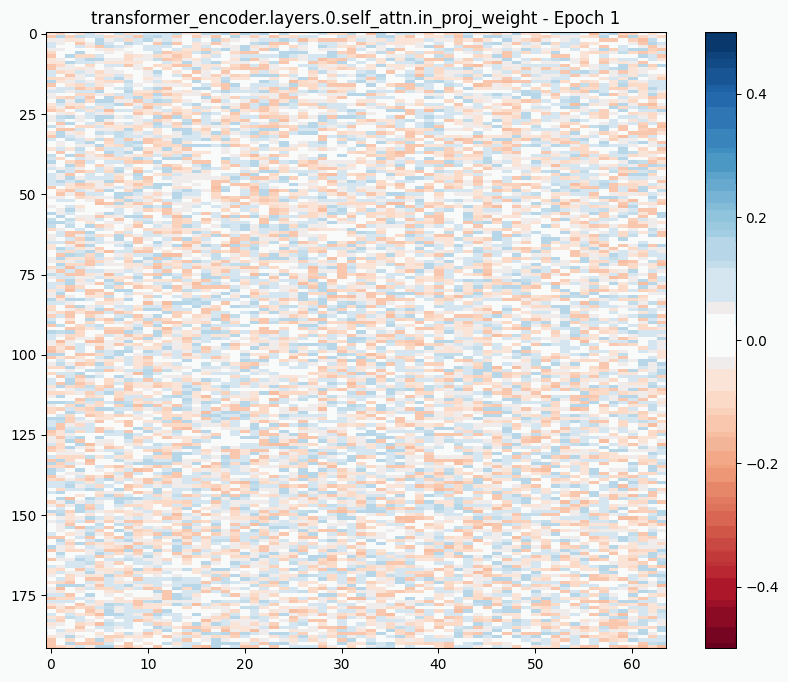

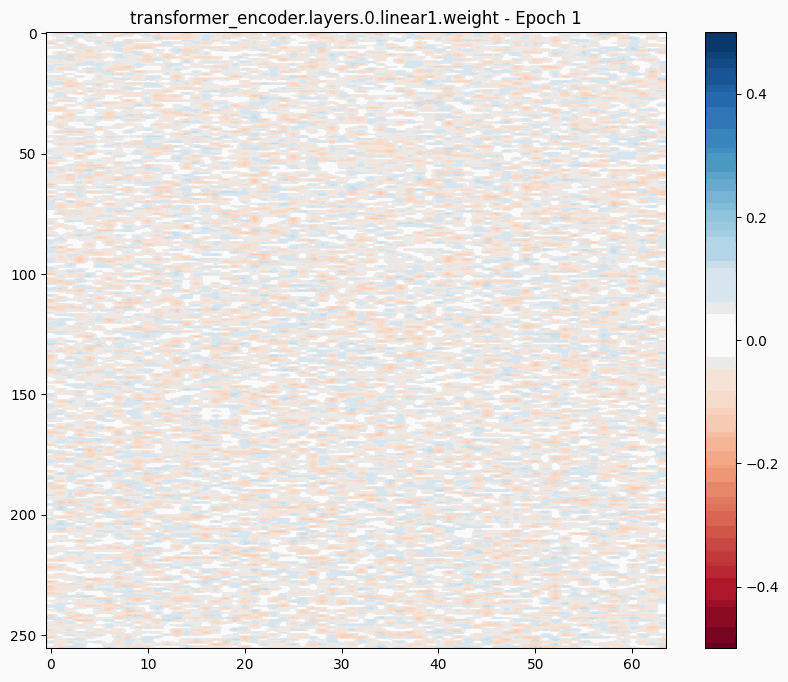

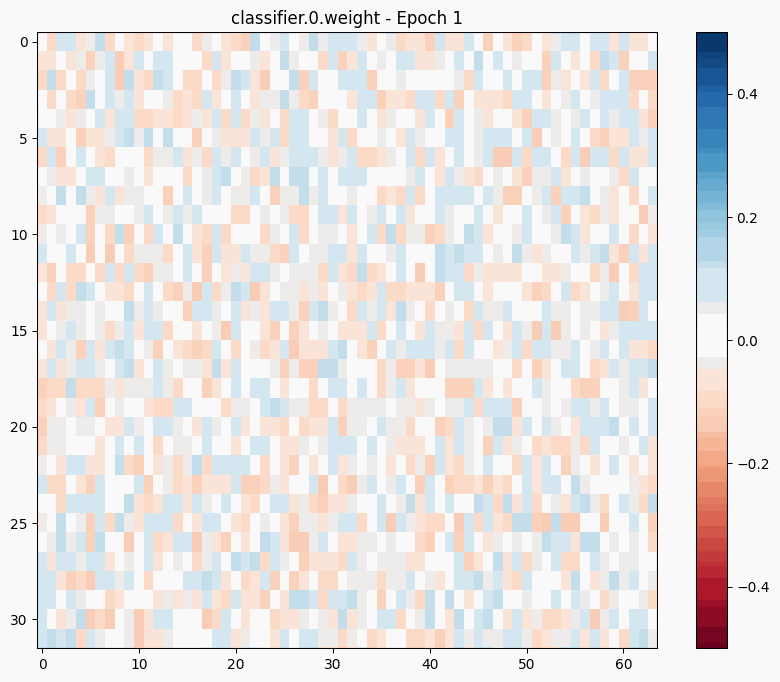

In [2]:
from IPython.display import Image, display

# View all GIFs
display(Image('weight_gifs/embedding_weight_updates.gif'))
display(Image('weight_gifs/transformer_encoder_layers_0_self_attn_in_proj_weight_updates.gif'))
display(Image('weight_gifs/transformer_encoder_layers_0_linear1_weight_updates.gif'))
display(Image('weight_gifs/classifier_0_weight_updates.gif'))

In [ ]:
print("Ma Kali")

Ma Kali
